In [1]:
# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import tree, metrics
from sklearn import preprocessing
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add constant for SM

In [2]:
# Load data set, drop col with numbers, drop high Pearson columns
data = pd.read_csv("marital_satisfaction_data_wrangled_final.csv")
data = data.drop(['Unnamed: 0','spouse_satisfaction','relationship_satisfaction'], axis=1)

# Drop Croatia + Catholic (highest n's)
data = pd.get_dummies(data, prefix=['rel','cnty'], columns=['religion','country'])
data = data.drop(['rel_Catholic','cnty_Croatia'], axis=1)



data['marital_satisfaction'].describe()

count    7178.000000
mean        1.739203
std         1.452407
min        -3.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: marital_satisfaction, dtype: float64

In [3]:
X = data.drop(['marital_satisfaction'], axis=1)
X = sm.add_constant(X)
y = data.marital_satisfaction

In [4]:
# VIF on unscaled data

vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"]=[variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif = vif.sort_values(by='VIF', ascending=False).reset_index(drop=True)
vif

,feature,VIF
0,const,104.739405
1,rel_Muslim,7.163801
2,cnty_India,6.530549
3,rel_Hindu,5.868178
4,marriage_duration_years,5.446671
...,...,...
66,rel_Other,1.088229
67,sex,1.077339
68,rel_Jehovah,1.072540
69,rel_Jewish,1.039219


In [5]:
# Kept eliminating columns until VIF was under 10 for all features
# Add constant to X, then do VIF again
# Aim for 5

Xvif10 = X.drop(['rel_Muslim', 'cnty_India', 'marriage_duration_years'], axis=1)
vif = pd.DataFrame()
vif["feature"] = Xvif10.columns
vif["VIF"]=[variance_inflation_factor(Xvif10.values, i) for i in range(len(Xvif10.columns))]
vif = vif.sort_values(by='VIF', ascending=False).reset_index(drop=True)
vif

,feature,VIF
0,const,91.100539
1,rel_Orthodox,4.098410
2,indv_pride_in_children,3.083480
3,spouse_pride,2.542765
4,cnty_Russia,2.523981
...,...,...
63,rel_Other,1.075812
64,sex,1.070384
65,rel_Jehovah,1.061958
66,rel_Jewish,1.030952


In [6]:
# Scale X with Robust Scaler

cols= list(X.columns)
scaler = preprocessing.RobustScaler()
Xsc = scaler.fit_transform(X)
Xsc = pd.DataFrame(Xsc, columns=cols)
Xsc


,const,sex,age,marriage_duration_years,num_children_total,num_children_inhome,edu_level,material_situation,religiosity,pension,...,cnty_Romania,cnty_Russia,cnty_Saudi Arabia,cnty_Slovakia,cnty_South Korea,cnty_Spain,cnty_Switzerland,cnty_Turkey,cnty_U.K.,cnty_Uganda
0,0.0,-1.0,-1.058824,-0.555556,-2.0,-0.5,0.0,0.0,0.0,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.0,-0.588235,-0.500000,-1.0,-0.5,0.0,0.0,1.0,-0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,-0.529412,-0.277778,-2.0,-0.5,0.0,0.0,0.0,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-1.0,-0.529412,-0.277778,-1.0,0.0,0.0,0.0,1.0,-1.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-1.0,-0.647059,-0.166667,-2.0,-0.5,-1.0,1.0,0.5,-1.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173,0.0,-1.0,-0.411765,-0.277778,0.0,1.0,0.0,2.0,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7174,0.0,-1.0,-0.176471,-0.333333,2.0,1.5,0.0,0.0,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7175,0.0,-1.0,-0.411765,-0.555556,-1.0,0.0,0.0,1.0,1.5,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7176,0.0,-1.0,-0.705882,-0.500000,0.0,0.5,0.0,1.0,1.5,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# VIF for scaled data
# Add constant

vifsc = pd.DataFrame()
vifsc["feature"] = Xsc.columns
vifsc["VIF"]=[variance_inflation_factor(Xsc.values, i) for i in range(len(Xsc.columns))]
vifsc.sort_values(by='VIF', ascending=False).head(n=10)

# Is this done correctly? If so, do I basically keep everything? (except possibly duration)

C:\Users\webge\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,feature,VIF
33,rel_Muslim,9.137914
49,cnty_India,6.354239
30,rel_Hindu,6.078286
3,marriage_duration_years,5.720534
2,age,5.092878
51,cnty_Iran,4.949703
35,rel_Orthodox,4.612692
24,indv_pride_in_children,4.218453
20,natl_pride_in_children,3.595851
68,cnty_Turkey,3.363938


In [8]:
# Kept eliminating columns until VIF was under 5 for all features, scaled this time

Xscvif5 = Xsc.drop(['rel_Muslim', 'cnty_India', 'marriage_duration_years'], axis=1)
vif = pd.DataFrame()
vif["feature"] = Xscvif5.columns
vif["VIF"]=[variance_inflation_factor(Xscvif5.values, i) for i in range(len(Xscvif5.columns))]
vif = vif.sort_values(by='VIF', ascending=False).reset_index(drop=True)
vif

C:\Users\webge\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,feature,VIF
0,rel_Orthodox,4.353527
1,indv_pride_in_children,4.197491
2,natl_pride_in_children,3.582275
3,spouse_pride,3.329027
4,spouse_attraction,3.233326
...,...,...
63,rel_Other,1.083592
64,rel_Jehovah,1.069476
65,rel_Jewish,1.036192
66,rel_Evangelic,1.008569


In [9]:
# classifier 0 not unhappy, 1 unhappy

y.replace(to_replace=[0,1,2,3], value=0, inplace=True)
y.replace(to_replace=[-3,-2,-1], value=1, inplace=True)
y.value_counts()

0    6533
1     645
Name: marital_satisfaction, dtype: int64

In [10]:
# Logistic Reg, Use scaled
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(Xscvif5,y,test_size=.25, random_state=8)
# Random Forest, Use unscaled? Could also use scaled, more vars after all
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(Xvif10,y,test_size=.25, random_state=8)
# SVM, Use scaled
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(Xscvif5,y,test_size=.25, random_state=8)


In [11]:
# Initiate Logistic Reg

log_reg = LogisticRegression(penalty='elasticnet',solver='saga',max_iter=5000)

In [12]:
#Cross validate. How to choose which params to test?

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'l1_ratio': [0,.5,1]
             }

In [ ]:
#lr_cv = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')
#
#lr_cv.fit(Xscvif5,y)
#lr_cv.best_estimator_

In [13]:
log_reg = LogisticRegression(C=0.01, l1_ratio=0.5, max_iter=5000, penalty='elasticnet', solver='saga')
log_reg.fit(X_train_logit, y_train_logit)
y_pred_logit = log_reg.predict_proba(X_test_logit)[:,1]

In [14]:
from sklearn.metrics import roc_curve, auc

In [15]:
logit_fpr, logit_tpr, threshold = roc_curve(y_test_logit, y_pred_logit)
auc_logit = auc(logit_fpr, logit_tpr)


print(auc_logit)

0.8322821246550061


In [16]:
log_reg.score(X_test_logit, y_test_logit)

0.9348189415041783

In [17]:
# previously tried other depths, estimators

rf=ensemble.RandomForestClassifier()

param_grid = { 
    'n_estimators': [10, 25, 50, 75, 100],
    'max_features': [None, 'auto', 'log2'],
    'max_depth' : [2,3,4,5,6],
}

In [18]:
#rf_cv = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc')
#
#rf_cv.fit(Xvif10,y)
#rf_cv.best_estimator_

In [19]:
# Train random forest

rf=ensemble.RandomForestClassifier(max_depth=2, n_estimators=50)
rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict_proba(X_test_rf)[:,1]
y_predict_rf = rf.predict(X_test_rf)
y_predict_rf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [20]:
rf_fpr, rf_tpr, threshold = roc_curve(y_test_rf, y_pred_rf)
auc_rf = auc(rf_fpr, rf_tpr)
print(auc_rf)

0.8569460200816132


In [21]:
fi_rf = pd.DataFrame(rf.feature_importances_, index = X_train_rf.columns, columns=['importance']).sort_values('importance', ascending=False)
fi_rf

,importance
spouse_love,0.218617
spouse_pride,0.142988
enjoy_spouse_company,0.128849
spouse_respect,0.109844
spouse_attraction,0.085737
...,...
rel_Spiritualism,0.000000
cnty_Canada,0.000000
cnty_China,0.000000
cnty_Estonia,0.000000


In [22]:
from sklearn.svm import SVC

In [23]:
svc=SVC()
# keep param grid simple
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  }

In [24]:
#svc_cv = GridSearchCV(svc, param_grid, cv=10, scoring='roc_auc')
#
#svc_cv.fit(Xscvif5,y)
#svc_cv.best_estimator_

In [25]:

#Train SVM

svc=SVC(C=.001, probability=True)
svc.fit(X_train_svc, y_train_svc)
y_pred_svc = svc.predict_proba(X_test_svc)[:,1]

In [26]:
svc_fpr, svc_tpr, threshold = roc_curve(y_test_svc, y_pred_svc)
auc_svc = auc(svc_fpr, svc_tpr)
print(auc_svc)

0.7883472459743646


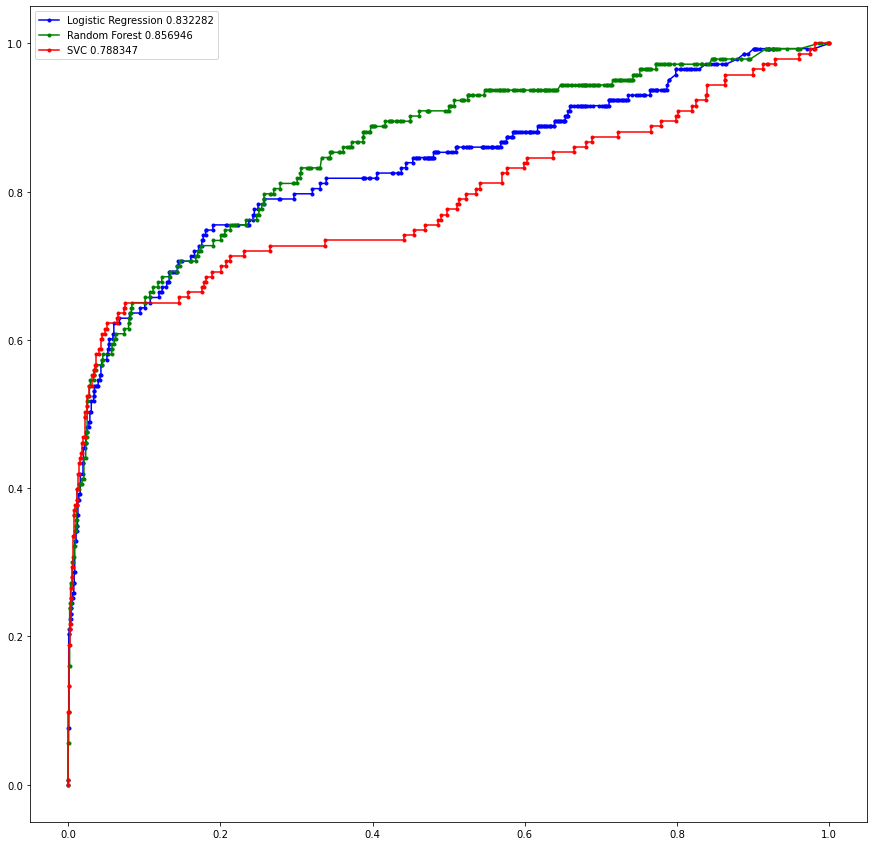

In [28]:

fig, heat = plt.subplots(figsize = (15,15))
plt.plot(logit_fpr, logit_tpr, marker='.', color='blue', label='Logistic Regression %f' % auc_logit)
plt.plot(rf_fpr, rf_tpr, marker='.', color='green', label='Random Forest %f' % auc_rf)
plt.plot(svc_fpr, svc_tpr, marker='.', color='red', label='SVC %f' % auc_svc)

plt.legend()
plt.savefig('auc_comp.png')
plt.show()

In [36]:
Xscvif5.columns

Index(['const', 'sex', 'age', 'num_children_total', 'num_children_inhome',
       'edu_level', 'material_situation', 'religiosity', 'pension',
       'enjoy_spouse_company', 'happiness', 'spouse_attraction',
       'spouse_enjoy_doing_things_together', 'spouse_enjoy_cuddling',
       'spouse_respect', 'spouse_pride', 'spouse_romance', 'spouse_love',
       'natl_pride_in_parents', 'natl_pride_in_children',
       'natl_aging_parents_live_with_children',
       'natl_children_live_at_home_marraige', 'indv_pride_in_parents',
       'indv_pride_in_children', 'indv_aging_parents_live_with_children',
       'indv_children_live_at_home_marraige', 'rel_Buddhist',
       'rel_Did not answer', 'rel_Evangelic', 'rel_Hindu', 'rel_Jehovah',
       'rel_Jewish', 'rel_None', 'rel_Orthodox', 'rel_Other', 'rel_Protestant',
       'rel_Spiritualism', 'cnty_Brazil ', 'cnty_Bulgaria', 'cnty_Canada',
       'cnty_China', 'cnty_Estonia', 'cnty_Germany', 'cnty_Ghana',
       'cnty_Greece', 'cnty_HongKong', 

In [37]:
rel_cols = ['enjoy_spouse_company', 'spouse_attraction',
       'spouse_enjoy_doing_things_together', 'spouse_enjoy_cuddling',
       'spouse_respect', 'spouse_pride', 'spouse_romance', 'spouse_love',]

In [38]:
Xnon_rel = Xscvif5.drop(rel_cols, axis=1)
Xnon_rel

,const,sex,age,num_children_total,num_children_inhome,edu_level,material_situation,religiosity,pension,happiness,...,cnty_Romania,cnty_Russia,cnty_Saudi Arabia,cnty_Slovakia,cnty_South Korea,cnty_Spain,cnty_Switzerland,cnty_Turkey,cnty_U.K.,cnty_Uganda
0,0.0,-1.0,-1.058824,-2.0,-0.5,0.0,0.0,0.0,-0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.0,-0.588235,-1.0,-0.5,0.0,0.0,1.0,-0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,-0.529412,-2.0,-0.5,0.0,0.0,0.0,-0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-1.0,-0.529412,-1.0,0.0,0.0,0.0,1.0,-1.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-1.0,-0.647059,-2.0,-0.5,-1.0,1.0,0.5,-1.333333,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173,0.0,-1.0,-0.411765,0.0,1.0,0.0,2.0,0.0,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7174,0.0,-1.0,-0.176471,2.0,1.5,0.0,0.0,0.0,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7175,0.0,-1.0,-0.411765,-1.0,0.0,0.0,1.0,1.5,-0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7176,0.0,-1.0,-0.705882,0.0,0.5,0.0,1.0,1.5,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [39]:
# Random Forest, Use unscaled? Could also use scaled, more vars after all
X_train, X_test, y_train, y_test = train_test_split(Xnon_rel,y,test_size=.25, random_state=8)


In [50]:
rf=ensemble.RandomForestClassifier(max_depth=2, n_estimators=25)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:,1]
y_predict = rf.predict(X_test)
y_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [60]:
rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred)
auc_rf = auc(rf_fpr, rf_tpr)
print(auc_rf)

0.7822728119338289


In [55]:
final_cols = ['const', 'sex', 'num_children_total', 'num_children_inhome',
       'edu_level', 'religiosity', 'pension',
       'enjoy_spouse_company', 'spouse_attraction',
       'spouse_enjoy_doing_things_together', 'spouse_enjoy_cuddling',
       'spouse_respect', 'spouse_pride', 'spouse_romance', 'spouse_love',
       'natl_pride_in_children',
       'natl_aging_parents_live_with_children',
       'natl_children_live_at_home_marraige', 'indv_aging_parents_live_with_children',
       'indv_children_live_at_home_marraige', 'rel_Buddhist',
       'rel_Did not answer', 'rel_Evangelic', 'rel_Hindu', 'rel_Jehovah',
       'rel_Jewish', 'rel_None', 'rel_Orthodox', 'rel_Other', 'rel_Protestant',
       'rel_Spiritualism', 'cnty_Brazil ', 'cnty_Bulgaria', 'cnty_Canada',
       'cnty_China', 'cnty_Estonia', 'cnty_Germany', 'cnty_Ghana',
       'cnty_Greece', 'cnty_HongKong', 'cnty_Hungary', 'cnty_Indonesia',
       'cnty_Iran ', 'cnty_Italy', 'cnty_Kazakhstan', 'cnty_Kenia',
       'cnty_Malaysia', 'cnty_Mexico', 'cnty_Nigeria ', 'cnty_Pakistan',
       'cnty_Poland ', 'cnty_Portugal', 'cnty_Romania', 'cnty_Russia',
       'cnty_Saudi Arabia', 'cnty_Slovakia', 'cnty_South Korea', 'cnty_Spain ',
       'cnty_Switzerland', 'cnty_Turkey ', 'cnty_U.K.', 'cnty_Uganda']

In [70]:
Xfinal = Xscvif5.drop(final_cols, axis=1)
Xfinal

,age,material_situation,happiness,natl_pride_in_parents,indv_pride_in_parents,indv_pride_in_children
0,-1.058824,0.0,0.0,0.5,0.5,0.0
1,-0.588235,0.0,0.0,0.0,0.5,0.0
2,-0.529412,0.0,0.0,0.0,0.5,0.0
3,-0.529412,0.0,0.0,-0.5,0.5,0.0
4,-0.647059,1.0,-1.0,-0.5,0.5,0.0
...,...,...,...,...,...,...
7173,-0.411765,2.0,0.0,0.0,0.0,-1.0
7174,-0.176471,0.0,0.0,0.0,-0.5,-1.0
7175,-0.411765,1.0,0.0,0.5,0.5,-1.0
7176,-0.705882,1.0,0.0,0.5,-0.5,-2.0


In [71]:
# Random Forest, Use unscaled? Could also use scaled, more vars after all
X_train, X_test, y_train, y_test = train_test_split(Xfinal,y,test_size=.25, random_state=8)


In [85]:
rf=ensemble.RandomForestClassifier(max_depth=2, n_estimators=25)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:,1]
y_predict = rf.predict(X_test)
y_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [86]:
rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred)
auc_rf = auc(rf_fpr, rf_tpr)
print(auc_rf)

0.7851936199393826


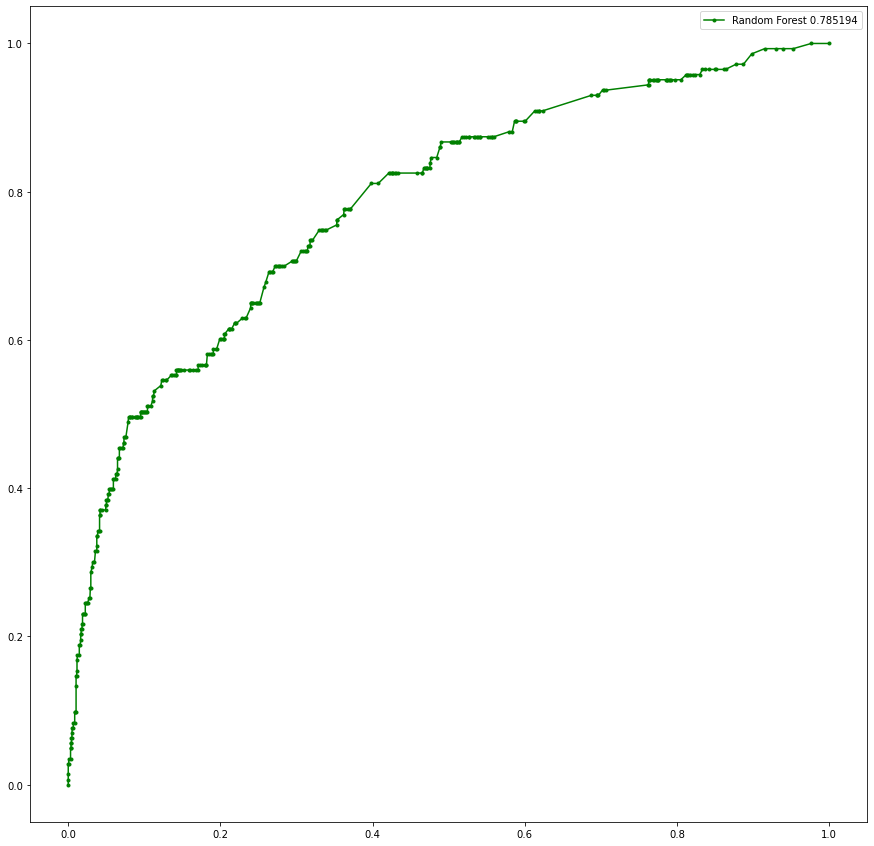

In [87]:

fig, heat = plt.subplots(figsize = (15,15))
plt.plot(rf_fpr, rf_tpr, marker='.', color='green', label='Random Forest %f' % auc_rf)

plt.legend()
plt.savefig('auc_rf.png')
plt.show()

In [88]:
fi_rf = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
fi_rf

,importance
happiness,0.650610
material_situation,0.152878
natl_pride_in_parents,0.078618
age,0.049320
indv_pride_in_children,0.034507
indv_pride_in_parents,0.034066


In [95]:
y_pred.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [97]:
# model eval for RF
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict)

array([[1652,    0],
       [ 143,    0]], dtype=int64)

In [91]:
# model eval for RF
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)

0.9203342618384401

In [92]:
# model eval for RF
from sklearn.metrics import recall_score
recall_score(y_test, y_predict)

0.0

In [93]:
# model eval for RF
from sklearn.metrics import precision_score
precision_score(y_test, y_predict)

C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [94]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predict)

0.0

In [83]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1652
           1       0.00      0.00      0.00       143

    accuracy                           0.92      1795
   macro avg       0.46      0.50      0.48      1795
weighted avg       0.85      0.92      0.88      1795



C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
# threshold tuning
from sklearn.metrics import precision_recall_curve
pre, rec, th = precision_recall_curve(y_test, y_pred)

In [101]:
def proba_classifier(y_pred, t):
    return [1 if y >= t else 0 for y in y_pred]

In [102]:
def th_tester(pre, rec, th, t=.5):
    y_pred_class = proba_classifier(y_pred, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_class), columns=['pred 0', 'pred 1'], index=['actual 0', 'actual 1']))
    print(classification_report(y_test, y_pred_class))


In [131]:
th_tester(pre, rec, th, t=.078
        )

          pred 0  pred 1
actual 0    1237     415
actual 1      50      93
              precision    recall  f1-score   support

           0       0.96      0.75      0.84      1652
           1       0.18      0.65      0.29       143

    accuracy                           0.74      1795
   macro avg       0.57      0.70      0.56      1795
weighted avg       0.90      0.74      0.80      1795



In [117]:
from sklearn.metrics import fbeta_score

f1_scores = []
f0_5_scores = []
f2_scores = []
precision_scores = []
recall_scores = []

probability_thresholds = np.linspace(0, 1, num=100)

for p in probability_thresholds:

    y_test_preds = []

    for prob in y_pred:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    f1 = f1_score(y_test, y_test_preds)
    f0_5 = fbeta_score(y_test, y_test_preds, beta=0.5)
    f2 = fbeta_score(y_test, y_test_preds, beta=2)
    prec = precision_score(y_test, y_test_preds)
    rec = recall_score(y_test, y_test_preds)
        
    f1_scores.append(f1)
    f0_5_scores.append(f0_5)
    f2_scores.append(f2)
    precision_scores.append(prec)
    recall_scores.append(rec)

C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision 

C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\webge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision 

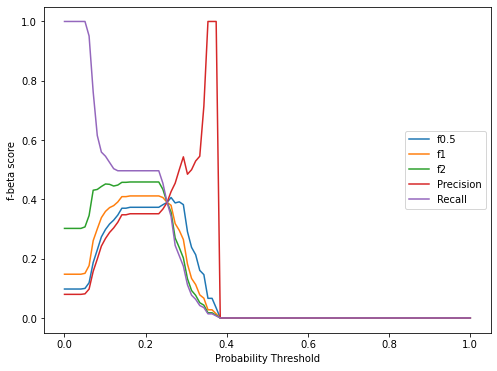

In [118]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(probability_thresholds, f0_5_scores , label='f0.5')
ax.plot(probability_thresholds, f1_scores, label='f1')
ax.plot(probability_thresholds, f2_scores, label='f2')
ax.plot(probability_thresholds, precision_scores, label='Precision')
ax.plot(probability_thresholds, recall_scores, label='Recall')
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('f-beta score')
ax.legend(loc='center right');

In [108]:
from numpy import sqrt
from numpy import argmax
# best threshold using geo mean
gmeans = sqrt(rf_tpr * (1-rf_fpr))

best = argmax(gmeans)
th[best]

#might have done this wrong, doesn't line up with precision-recall curve

0.07840526885923943

In [109]:
def prerec_plot(pres, recs, ths):
    plt.figure(figsize=(10,10))
    plt.title('Preicision and Recall curves')
    plt.plot(ths, pres[:-1], "#00D9FF", label='Precision')
    plt.plot(ths, recs[:-1], "#FF002B", label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.savefig('prerec.png')

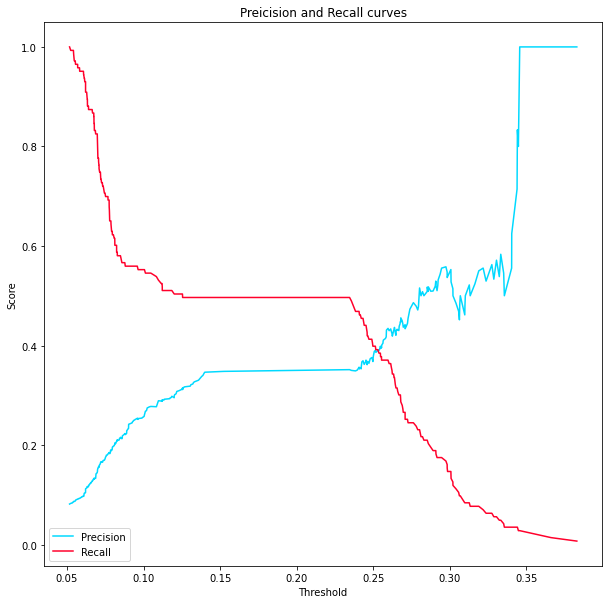

In [110]:
prerec_plot(pre, rec, th)